**Tables are loaded via HVR into GP datalake from various ERPs.**

**Hash Audit is done to check if source and target tables are in sync and data is same.**

**For Hash Audit we are using a java script which is scheduled to  run daily for all the source systems.**

**After running hash audit on any source system the results are stored in data_audit_results table .
using that data of  data_audit_results table to find out below things .**

     1. If there is any common failure pattern ? eg. a table always failing for Pk only error
     2. Which source system/table has the highest no. failures ?
     3. Which day of the week failures are more ?
     4. Which source_system/table has highest % of errors ?
    

In [1]:
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#from sshtunnel import SSHTunnelForwarder
import getpass
import datetime
#import dask.dataframe as dd
#import dask.array as da

**Considering the sample data for 1 month from data_audit_results table** *(Max which my machine will support)*

**Data was brought into local by using pg_dump.**


In [2]:
#c_size =5000
df_raw = pd.read_csv('C:/GE_WORKS/audit.csv',sep=',',index_col=0)# contains 1 month data due to infra constraint)


In [3]:
df_raw.columns

Index(['end_time', 'audit_type', 'source_system_name', 'table_name',
       'total_in_source', 'total_in_mirror', 'source_only_count',
       'source_only_keys', 'mirror_only_count', 'mirror_only_keys',
       'mismatch_count', 'mismatch_keys', 'source_query', 'target_query',
       'status', 'environment', 'source_only_error_percent',
       'mirror_only_error_percent', 'mismatch_error_percent', 'audited_date',
       'revalidation', 'target_name', 'overll_source_count',
       'overall_target_count', 'reason', 'latency_keys'],
      dtype='object')

In [4]:
audit = df_raw[['source_system_name','table_name', 'total_in_source', 'total_in_mirror', 'source_only_count','mirror_only_count','mismatch_count','source_only_error_percent','mirror_only_error_percent', 'mismatch_error_percent', 'audited_date','target_name']].copy()

audit['audited_date'] = pd.to_datetime(df_raw['audited_date'], errors='coerce')

**Sample rows of table**

In [5]:
audit.head(5)

,source_system_name,table_name,total_in_source,total_in_mirror,source_only_count,mirror_only_count,mismatch_count,source_only_error_percent,mirror_only_error_percent,mismatch_error_percent,audited_date,target_name
start_time,,,,,,,,,,,,
2019-04-16 06:00:06,PNUNOP01,qp_qualifiers,0,0,0,0,0,0,0,0,2019-04-15,PWR
2019-04-16 12:10:07,GPW_POWERMAX_400_PROD,lips,828,828,0,0,828,0,0,0,2019-04-15,PWR
2019-04-16 06:00:06,PNUNOP01,gl_je_lines,34596,34596,0,0,0,0,0,0,2019-04-15,PWR
2019-04-16 12:10:07,GPW_POWERMAX_400_PROD,vbrk,13,13,0,0,13,0,0,0,2019-04-15,PWR
2019-04-16 06:00:06,PNUNOP01,fa_categories_b,0,0,0,0,0,0,0,0,2019-04-15,PWR


**We are splitting the column audited date into Week_no and  Week_day**

**The week day is left shited by 1 value as the audit runs for previous day**

**Week Day --> Monday is 0 and goes till Sunday as --> 6**

In [6]:
audit['Week_no'] = audit['audited_date'].dt.week

audit['Weekday'] = (audit['audited_date'] - datetime.timedelta(days=1)).dt.weekday

In [7]:
audit.head(2)

,source_system_name,table_name,total_in_source,total_in_mirror,source_only_count,mirror_only_count,mismatch_count,source_only_error_percent,mirror_only_error_percent,mismatch_error_percent,audited_date,target_name,Week_no,Weekday
start_time,,,,,,,,,,,,,,
2019-04-16 06:00:06,PNUNOP01,qp_qualifiers,0,0,0,0,0,0,0,0,2019-04-15,PWR,16,6
2019-04-16 12:10:07,GPW_POWERMAX_400_PROD,lips,828,828,0,0,828,0,0,0,2019-04-15,PWR,16,6


In [8]:
#plot_data = df_1.astype(float)
audit.columns



Index(['source_system_name', 'table_name', 'total_in_source',
       'total_in_mirror', 'source_only_count', 'mirror_only_count',
       'mismatch_count', 'source_only_error_percent',
       'mirror_only_error_percent', 'mismatch_error_percent', 'audited_date',
       'target_name', 'Week_no', 'Weekday'],
      dtype='object')

**Bucketing the errors and based on below column conditions we are creating a new column as error_type**

**('source_only_count' > 0 & 'mirror_only_count' >  0 & 'mismatch_count' > 0)                    -->*all_mismatch**
                                                                                        
**('source_only_count' > 0 & 'mirror_only_count' == 0 & 'mismatch_count'== 0)                    -->*src_only**
                                                                                        
**('source_only_count' > 0 & 'mirror_only_count' >  0 & 'mismatch_count'== 0)                    -->*src_and_mirror**
                                                                                        
**('source_only_count' > 0 & 'mirror_only_count' == 0 & 'mismatch_count'>  0)                    -->*src_and_pk**
                                                                                        
**('source_only_count' == 0 & 'mirror_only_count' > 0 & 'mismatch_count'>  0)                    -->*mirror_and_pk**
                                                                                        
**('source_only_count' == 0 & 'mirror_only_count'== 0 & 'mismatch_count' > 0)                    -->*pk_only**
                                                                                        
**('source_only_count'==  0 & 'mirror_only_count' > 0 & 'mismatch_count'== 0)                    -->*mirror_only**
                                                                                        
**('source_only_count' == 0 & 'mirror_only_count'== 0 & 'mismatch_count'== 0)                    -->*no_error**

In [9]:
import numpy as np
#choices = ['all_mismatch','src_only']
choices = ['all_mismatch','src_only','src_and_mirror','src_and_pk','mirror_and_pk','pk_only','mirror_only','no_error']
#conditions = [(df_1['source_only_count'] > 0) & (df_1['mirror_only_count'] > 0) & (df_1['mismatch_count'] > 0),(df_1['source_only_count'] > 0) & (df_1['mirror_only_count'] == 0) & (df_1['mismatch_count']== 0)] 
conditions = [(audit['source_only_count'] > 0) & (audit['mirror_only_count'] > 0) & (audit['mismatch_count'] > 0),(audit['source_only_count'] > 0) & (audit['mirror_only_count'] == 0) & (audit['mismatch_count']== 0),(audit['source_only_count'] > 0) & (audit['mirror_only_count'] > 0) & (audit['mismatch_count']== 0),(audit['source_only_count'] > 0) & (audit['mirror_only_count'] == 0) & (audit['mismatch_count']> 0),(audit['source_only_count'] == 0) & (audit['mirror_only_count'] > 0) & (audit['mismatch_count']> 0),(audit['source_only_count'] == 0) & (audit['mirror_only_count'] == 0) & (audit['mismatch_count'] > 0),(audit['source_only_count']== 0) & (audit['mirror_only_count'] > 0) & (audit['mismatch_count']== 0),(audit['source_only_count'] == 0) & (audit['mirror_only_count'] == 0) & (audit['mismatch_count']== 0)]
pwr_audit = audit

In [10]:
pwr_audit['err_type'] = np.select(conditions, choices, default='None')


In [11]:
pwr_audit.head(2)
pwr_err_100_more = pwr_audit[pwr_audit['mismatch_error_percent']>100]
pwr_err_100_more.head(2)

,source_system_name,table_name,total_in_source,total_in_mirror,source_only_count,mirror_only_count,mismatch_count,source_only_error_percent,mirror_only_error_percent,mismatch_error_percent,audited_date,target_name,Week_no,Weekday,err_type
start_time,,,,,,,,,,,,,,,
2019-04-16 12:15:12,GPSESP82,msc_supplies,999,969,30,0,969,0,0,3230,2019-04-15,PWR,16,6,src_and_pk
2019-04-16 05:13:03,PNEOLP01_ADMUSERPSP,taskx,1683,1682,1,0,30,0,0,3000,2019-04-15,PWR,16,6,src_and_pk


**Plotting a categorical plot graph to identify which error has occured most no. of times and is common on all weekdays** 

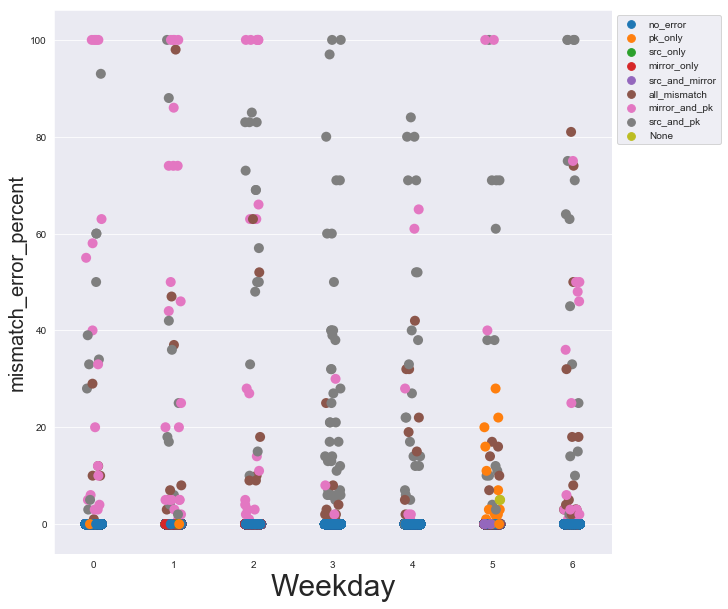

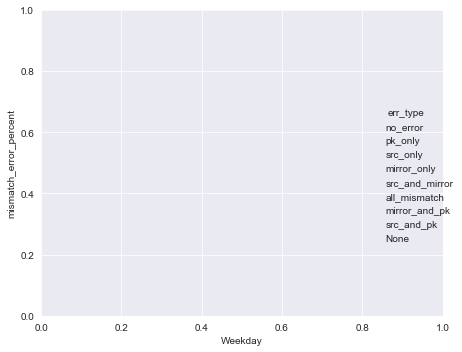

In [12]:
sns.set_style('darkgrid')
#plt.figure(figsize=(200,180))
fig,ax = plt.subplots(figsize=(10,10))
#df_new_data= pwr_audit_cnt[pwr_audit_cnt['table_name']<=100]

#sns.jointplot(x='mismatch_error_percent',y='Weekday',data=pwr_audit)
sns.catplot(ax=ax,x="Weekday", y="mismatch_error_percent",hue = "err_type", data=pwr_audit[pwr_audit['mismatch_error_percent']<=100],marker="o",s=10);
ax.set_xlabel("Weekday",fontsize=30)
ax.set_ylabel("mismatch_error_percent",fontsize=20)
ax.legend(bbox_to_anchor=(1,1))
plt.tight_layout()

In [13]:
from functools import reduce
pwr_audit_w0 = pwr_audit[(pwr_audit['Weekday'] ==0) & (pwr_audit['mismatch_error_percent'] >0 )]
pwr_audit_w1 = pwr_audit[(pwr_audit['Weekday'] ==1) & (pwr_audit['mismatch_error_percent'] >0 )]
pwr_audit_w2 = pwr_audit[(pwr_audit['Weekday'] ==2) & (pwr_audit['mismatch_error_percent'] >0 )]
pwr_audit_w3 = pwr_audit[(pwr_audit['Weekday'] ==3) & (pwr_audit['mismatch_error_percent'] >0 )]
pwr_audit_w4 = pwr_audit[(pwr_audit['Weekday'] ==4) & (pwr_audit['mismatch_error_percent'] >0 )]
pwr_audit_w5 = pwr_audit[(pwr_audit['Weekday'] ==5) & (pwr_audit['mismatch_error_percent'] >0 )]
pwr_audit_w6 = pwr_audit[(pwr_audit['Weekday'] ==6) & (pwr_audit['mismatch_error_percent'] >0 )]
#pwr_audit_all = [pwr_audit_w1,pwr_audit_w2, pwr_audit_w3]
pwr_audit_all = [pwr_audit_w0,pwr_audit_w1,pwr_audit_w2, pwr_audit_w3,pwr_audit_w4,pwr_audit_w5,pwr_audit_w6]#, on=['table_name'], how='inner')
pwr_audit_all = reduce(lambda left,right: pd.merge(left,right,on='table_name'), pwr_audit_all)


In [14]:
#del pwr_audit_all
pwr_audit_all.head(2)

,source_system_name_x,table_name,total_in_source_x,total_in_mirror_x,source_only_count_x,mirror_only_count_x,mismatch_count_x,source_only_error_percent_x,mirror_only_error_percent_x,mismatch_error_percent_x,...,mirror_only_count,mismatch_count,source_only_error_percent,mirror_only_error_percent,mismatch_error_percent,audited_date,target_name,Week_no,Weekday,err_type
0,GPSESP82,msc_supplies,90388,91335,0,947,381,100,100,40,...,0,969,0,0,3230,2019-04-15,PWR,16,6,src_and_pk
1,GPSESP82,msc_supplies,90388,91335,0,947,381,100,100,40,...,571,448,95,95,74,2019-04-15,PWR,16,6,all_mismatch


**The count plot shows no. of occurences of failure for source systems.** 

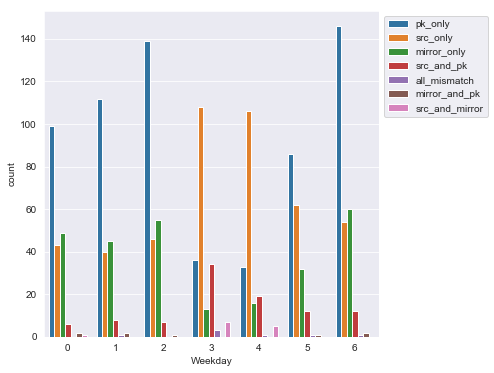

In [15]:
plt.figure(figsize=(6,6))

pwr_audit_GPW_POWERMAX_400_PROD=pwr_audit[(pwr_audit['source_system_name'] =='GPW_POWERMAX_400_PROD') & (pwr_audit['err_type']!='no_error')]
#pwr_audit_GPW_POWERMAX_400_PROD=pwr_audit[(pwr_audit['source_system_name'] =='GPW_POWERMAX_400_PROD') & (pwr_audit['err_type']!='no_error') & (pwr_audit['table_name']=='msc_supplies')]

#pwr_audit_GPSESP82=pwr_audit[(pwr_audit['source_system_name'] =='GPSESP82') & (pwr_audit['err_type']!='no_error') & (pwr_audit['table_name']=='msc_supplies')]

sns.countplot(x="Weekday",hue = "err_type", data=pwr_audit_GPW_POWERMAX_400_PROD[pwr_audit_GPW_POWERMAX_400_PROD['mismatch_error_percent']<=100])

#sns.countplot(x="Weekday",hue = "err_type", data=pwr_audit_GPSESP82[pwr_audit_GPSESP82['mismatch_error_percent']<=100])
plt.legend(bbox_to_anchor=(1,1))
#pwr_audit[(pwr_audit['Weekday'] ==0) & (pwr_audit['mismatch_error_percent'] >0 )]

**The above  histogram shows the distribution of error on weekdays** 

**Below we will get which are the tables or source systems those are commomly failing on all the weekdays**

*We can have various combinations here for predicting the failure may be a table will be failing only on Tuesday , Wednesday and Thrusday*

In [16]:
pwr_audit_all.table_name.unique()


array(['msc_supplies', 'rseg', 'eban', 'cost_event', 'mbew', 'marc'],
      dtype=object)

**To get the common source systems on each Week day from Monday to Sunday**

In [17]:
pwr_audit_all.source_system_name.unique()

array(['GPSESP82', 'PNOMVP01', 'SAP2ER0', 'GPW_POWERMAX_400_PROD',
       'PNNICP02'], dtype=object)

array('GPSESP82', 'PNOMVP01', 'SAP2ER0', 'GPW_POWERMAX_400_PROD',
       'PNNICP02', dtype=object)

In [18]:
pwr_audit_all.head(2)

,source_system_name_x,table_name,total_in_source_x,total_in_mirror_x,source_only_count_x,mirror_only_count_x,mismatch_count_x,source_only_error_percent_x,mirror_only_error_percent_x,mismatch_error_percent_x,...,mirror_only_count,mismatch_count,source_only_error_percent,mirror_only_error_percent,mismatch_error_percent,audited_date,target_name,Week_no,Weekday,err_type
0,GPSESP82,msc_supplies,90388,91335,0,947,381,100,100,40,...,0,969,0,0,3230,2019-04-15,PWR,16,6,src_and_pk
1,GPSESP82,msc_supplies,90388,91335,0,947,381,100,100,40,...,571,448,95,95,74,2019-04-15,PWR,16,6,all_mismatch


**The above result shows which source system has any type of  errors**

**END**